In [2]:
experiment_ids = [
	256, # ETR
	231, # Random Forest
	215, # Elastic Net,
	214, # Ridge
	210, # LASSO
	257, # ANN
	258, # CNN
	144, # NGB
	140, # PLS
	136, # XGBoost
	134, # SVR
	45, # GBR
]

In [3]:
models = {
	"Ridge": "Ridge",
	"LASSO": "\\gls{lasso}",
	"ElasticNet": "\\gls{enet}",
	"PLS": "\\gls{pls}",
	"SVR": "\\gls{svr}",
	"RandomForest": "\\gls{rf}",
	"NGB": "\\gls{ngboost}",
	"GBR": "\\gls{gbr}",
	"XGB": "\\gls{xgboost}",
	"ExtraTrees": "\\gls{etr}",
	"ANN": "\\gls{ann}",
	"CNN": "\\gls{cnn}",
}

In [4]:
import mlflow
import numpy as np

from pathlib import Path
from lib.reproduction import major_oxides

In [5]:
client = mlflow.tracking.MlflowClient()

data = {}

for experiment_id in experiment_ids:
	data[experiment_id] = client.search_runs(experiment_id)

data[experiment_ids[0]]

[<Run: data=<RunData: metrics={'rmse': 0.5906100342615692,
  'rmse_cv': 0.6424577351239987,
  'rmse_cv_1': 0.9116611135556014,
  'rmse_cv_2': 0.5921384021032136,
  'rmse_cv_3': 0.4801717587923786,
  'rmse_cv_4': 0.5858596660448013,
  'std_dev': 0.5402558765049962,
  'std_dev_cv': 0.6358257805769801,
  'std_dev_cv_1': 0.8899857936885336,
  'std_dev_cv_2': 0.5926943020924624,
  'std_dev_cv_3': 0.4771710417246671,
  'std_dev_cv_4': 0.5834519848022575}, params={'norm': '3', 'target': 'K2O'}, tags={'mlflow.runName': 'ExtraTrees_K2O',
  'mlflow.source.name': '/home/patrick/git/thesis-chemcam/baseline/venv/lib/python3.12/site-packages/ipykernel_launcher.py',
  'mlflow.source.type': 'LOCAL',
  'mlflow.user': 'patrick'}>, info=<RunInfo: artifact_uri='mlflow-artifacts:/256/61e0900a907044b19e47a1c5b8bbd7fa/artifacts', end_time=1717674250681, experiment_id='256', lifecycle_stage='active', run_id='61e0900a907044b19e47a1c5b8bbd7fa', run_name='ExtraTrees_K2O', run_uuid='61e0900a907044b19e47a1c5b8bbd7

In [6]:
results = {}
model_means = {}

# Iterate over the data dictionary and print the runs
for experiment_id, runs in data.items():
    for run in runs:
        # Check if the target parameter is present
        if "target" not in run.data.params:
            continue

        model_name = run.data.tags["mlflow.runName"].split("_")[0]
        latex_name = model_name

        if model_name in models:
            latex_name = models[latex_name]

        target = run.data.params["target"]
        rmse = run.data.metrics["rmse"]
        rmse_cv = run.data.metrics["rmse_cv"]
        std_dev = run.data.metrics["std_dev"]
        std_dev_cv = run.data.metrics["std_dev_cv"]

        # print(f"{model_name} - {target}, RMSE: {rmse}, RMSE CV: {rmse_cv}, STD DEV: {std_dev}, STD DEV CV: {std_dev_cv}")

        if model_name not in results:
            results[model_name] = {}
            model_means[model_name] = {"rmse": [], "rmse_cv": [], "std_dev": [], "std_dev_cv": []}

        results[model_name][target] = {
            "latex_name": latex_name,
            "rmse": rmse,
            "rmse_cv": rmse_cv,
            "std_dev": std_dev,
            "std_dev_cv": std_dev_cv,
        }

# Calculate the mean of the results
for model_name, targets in results.items():
    for target, metrics in targets.items():
        model_means[model_name]["rmse"].append(metrics["rmse"])
        model_means[model_name]["rmse_cv"].append(metrics["rmse_cv"])
        model_means[model_name]["std_dev"].append(metrics["std_dev"])
        model_means[model_name]["std_dev_cv"].append(metrics["std_dev_cv"])

    for metric, values in model_means[model_name].items():
        model_means[model_name][metric] = np.mean(values)

model_means

{'ExtraTrees': {'rmse': 1.5072687697357168,
  'rmse_cv': 2.034997855964912,
  'std_dev': 1.4923297467775463,
  'std_dev_cv': 2.0238300515812635},
 'RandomForest': {'rmse': 1.479336792192841,
  'rmse_cv': 2.027336025083496,
  'std_dev': 1.4659007904647976,
  'std_dev_cv': 2.0165291194136823},
 'ElasticNet': {'rmse': 2.2750723001885347,
  'rmse_cv': 3.539630347715189,
  'std_dev': 2.2481816256202283,
  'std_dev_cv': 3.5157429888621365},
 'Ridge': {'rmse': 1.5566741955630334,
  'rmse_cv': 2.1105993799717098,
  'std_dev': 1.5528313754587555,
  'std_dev_cv': 2.0965045358108814},
 'LASSO': {'rmse': 1.741347193850063,
  'rmse_cv': 2.2201897367283454,
  'std_dev': 1.7379561579653817,
  'std_dev_cv': 2.2077976772890984},
 'ANN': {'rmse': 1.8212803902648713,
  'rmse_cv': 2.481098633398783,
  'std_dev': 1.8086928861820286,
  'std_dev_cv': 2.4540239728750883},
 'CNN': {'rmse': 1.8803695565608425,
  'rmse_cv': 2.7791597939329336,
  'std_dev': 1.8570153101331826,
  'std_dev_cv': 2.7484009036787653},

In [7]:
# Generate the full table showing all the metrics
n_decimals = 3

latex_table = "\\begin{table*}[]\n"
latex_table += "\\centering\n"
latex_table += "\\resizebox{1\\textwidth}{!}{%\n"
latex_table += "\\begin{tabular}{l|cccc|cccc|cccc}\n"

model_keys = list(models.keys())

for i in range(0, len(model_keys), 3):
    chunk = model_keys[i:i+3]

    # Header row
    header_row = "Model"
    for model in chunk:
        header_row += f" & \\multicolumn{{4}}{{c}}{{{models[model]}}}"

    latex_table += header_row + " \\\\\n"

    # Metric row
    metric_row = "Metric"
    for _ in chunk:
        metric_row += " & \\multicolumn{1}{c}{RMSEP} & \\multicolumn{1}{c}{RMSECV} & \\multicolumn{1}{c}{Std. dev.} & \\multicolumn{1}{c}{Std. dev. CV}"

    latex_table += metric_row + " \\\\\n"
    latex_table += "\\hline\n"

    # Data rows
    for target in major_oxides:
        row = f"$\\ce{{{target}}}$"

        for model in chunk:
            if model in results and target in results[model]:
                metrics = results[model][target]
                row += f" & {metrics['rmse']:.{n_decimals}f} & {metrics['rmse_cv']:.{n_decimals}f} & {metrics['std_dev']:.{n_decimals}f} & {metrics['std_dev_cv']:.{n_decimals}f}"
            else:
                print(f"Missing data for {model} - {target}")
                row += " & - & - & - & -"

        latex_table += row + " \\\\\n"

    latex_table += "\\hline\n"

    # Mean rows
    mean_row = "Mean"
    for model in chunk:
        if model in model_means:
            mean_metrics = model_means[model]
            mean_row += f" & {mean_metrics['rmse']:.{n_decimals}f} & {mean_metrics['rmse_cv']:.{n_decimals}f} & {mean_metrics['std_dev']:.{n_decimals}f} & {mean_metrics['std_dev_cv']:.{n_decimals}f}"
        else:
            mean_row += " & - & - & - & -"

    latex_table += mean_row + " \\\\\n"
    latex_table += "\\hline\n"

latex_table += "\\end{tabular}%\n"
latex_table += "}\n"
latex_table += "\\caption{Initial results for the different models and metrics.}\n"
latex_table += "\\label{tab:init_results}\n"
latex_table += "\\end{table*}\n"

# Write the LaTeX table string to a file
path = Path("./../report_thesis/src/sections/results/init_results_table.tex")

with open(path, "w") as file:
    file.write(latex_table)

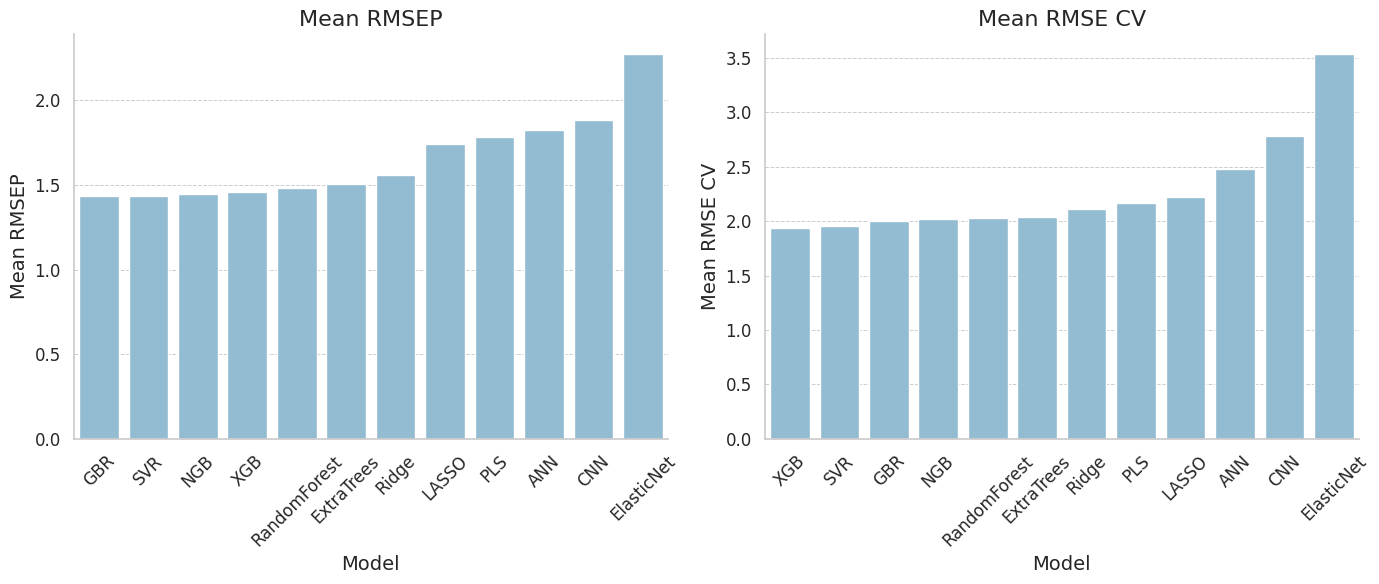

In [55]:

# Generate plots for the RMSE and RMSE CV values

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

model_names = list(model_means.keys())
rmse_values = [metrics["rmse"] for metrics in model_means.values()]
rmse_cv_values = [metrics["rmse_cv"] for metrics in model_means.values()]

data = pd.DataFrame({
    'Model': model_names,
    'RMSE': rmse_values,
    'RMSE_CV': rmse_cv_values
})

data_sorted_rmse = data.sort_values(by='RMSE')
data_sorted_rmse_cv = data.sort_values(by='RMSE_CV')

color = sns.color_palette("Blues")[2]

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot RMSE values
sns.barplot(x='Model', y='RMSE', data=data_sorted_rmse, color=color, ax=ax[0])
ax[0].set_title("Mean RMSEP", fontsize=16)
ax[0].set_ylabel("Mean RMSEP", fontsize=14)
ax[0].set_xlabel("Model", fontsize=14)
ax[0].tick_params(axis='x', rotation=45, labelsize=12)
ax[0].tick_params(axis='y', labelsize=12)
ax[0].grid(True, which='both', axis='y', linestyle='--', linewidth=0.7)
ax[0].grid(False, which='both', axis='x')
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)

# Plot RMSE CV values
sns.barplot(x='Model', y='RMSE_CV', data=data_sorted_rmse_cv, color=color, ax=ax[1])
ax[1].set_title("Mean RMSE CV", fontsize=16)
ax[1].set_ylabel("Mean RMSE CV", fontsize=14)
ax[1].set_xlabel("Model", fontsize=14)
ax[1].tick_params(axis='x', rotation=45, labelsize=12)
ax[1].tick_params(axis='y', labelsize=12)
ax[1].grid(True, which='both', axis='y', linestyle='--', linewidth=0.7)
ax[1].grid(False, which='both', axis='x')
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

# Save the plots to files
path = Path("./../report_thesis/src/images/init_results_rmses.png")
fig.savefig(path, dpi=300)
